# Title

## Introduction

Heart disease is the second leading cause of death in Canada, and occurs due to a build up of plaque in a person’s arteries. It can lead to a heart attack, heart failure, or death. Many factors can increase a person’s likelihood of getting a heart disease diagnosis, such as age and sex (via [Government of Canada](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html)). 
With this project, we want to answer the question: **Can a person’s age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas accurately predict if they will get diagnosed with heart disease?** To answer this question, we will be using a dataset from the Cleveland Clinic Foundation from 1988, which includes these various attributes for 303 patients, and whether or not they were diagnosed with heart disease.

## Preliminary Exploratory Data Analysis

In [10]:
#load packages
library(tidyverse) # needed for many functions used for data analysis, such as read_csv(), select(), etc.
library(repr) # needed to resize plots
library(tidymodels) # needed to split data into training and testing data and to perform classification

In [11]:
# read in dataset from web
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
download.file(url, "cleveland_data.zip")
unzip("cleveland_data.zip")
cleveland_original <- read_csv("processed.cleveland.data",
                          col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                        "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

# preview first 5 rows of the dataframe
head(cleveland_original, 5)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


In [12]:
# select for columns we'll use
cleveland <- select(cleveland_original, age, sex, trestbps, chol, fbs, exang, num)

# preview first 5 rows of new dataframe
head(cleveland, 5)

age,sex,trestbps,chol,fbs,exang,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,145,233,1,0,0
67,1,160,286,0,1,2
67,1,120,229,0,1,1
37,1,130,250,0,0,0
41,0,130,204,0,0,0


In [13]:
# split the data then make training and testing data
cleveland_split <- initial_split(cleveland, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

In [14]:
# Tables that report the number of observations in each class of sex, fasting blood sugar level, and if an individual has excercise induced angina.

#sex: (1 = male; 0 = female)
cleveland_train_sex <- cleveland_training |>
    group_by(sex) |>
    summarize(amount_of_individuals = n())

cleveland_train_sex

#fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
cleveland_train_fbs <- cleveland_training |>
    group_by(fbs) |>
    summarize(amount_of_individuals = n())

cleveland_train_fbs

#exang: exercise induced angina (1 = yes; 0 = no)
cleveland_train_exang <- cleveland_training |>
    group_by(exang) |>
    summarize(amount_of_individuals = n())

cleveland_train_exang

sex,amount_of_individuals
<dbl>,<int>
0,75
1,150


fbs,amount_of_individuals
<dbl>,<int>
0,189
1,36


exang,amount_of_individuals
<dbl>,<int>
0,163
1,62


In [15]:
# Table of means of the predictor variables we plan to use in our analysis
cleveland_train_means <- cleveland_training |>
    select(-num) |>
    map_df(mean)

cleveland_train_means

age,sex,trestbps,chol,fbs,exang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.65333,0.6666667,130.96,247.8133,0.16,0.2755556


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



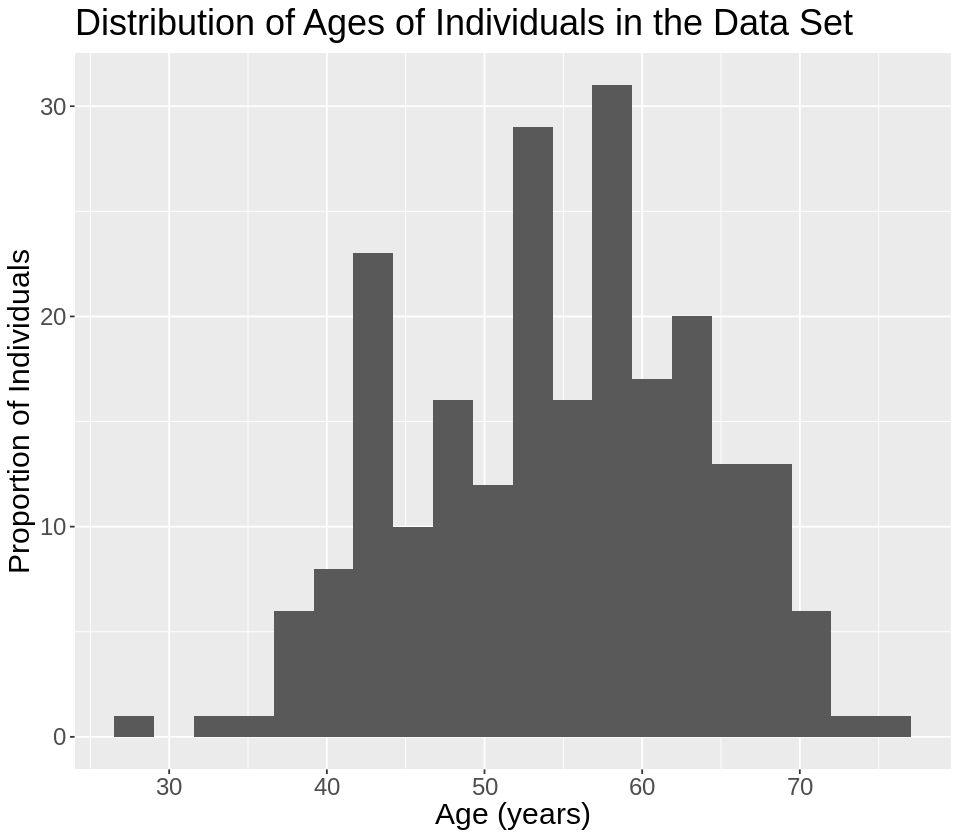

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



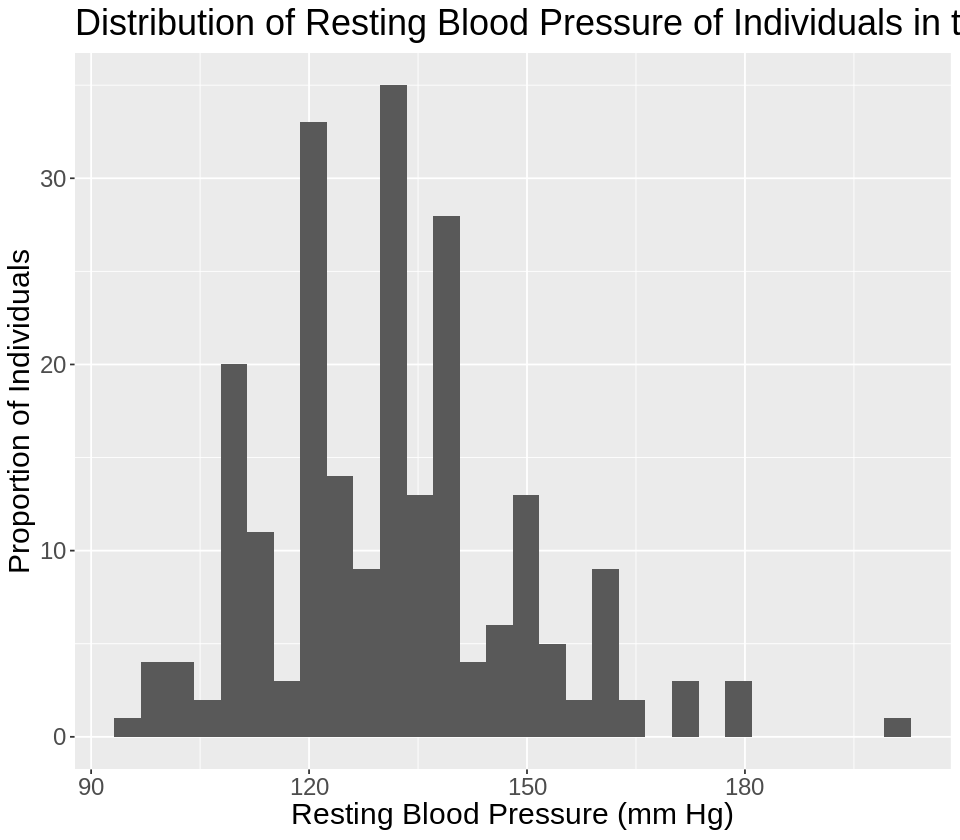

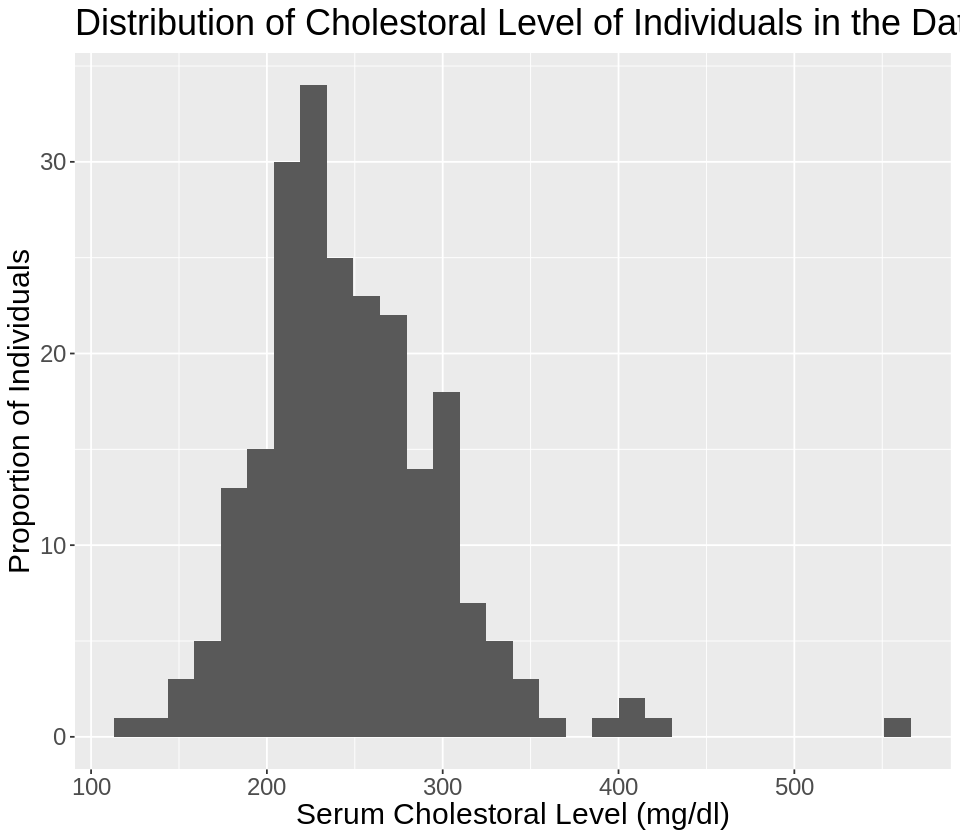

In [27]:
# histograms of non-binary variables
options(repr.plot.height = 7, repr.plot.width = 8)

# distribution of age
age_dist <- cleveland_training |>
    ggplot(aes(x = age)) +
    geom_histogram(bins = 20) +
    labs(x = "Age (years)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Ages of Individuals in the Data Set") +
    theme(text = element_text(size = 18))
age_dist

# distribution of trestbps
trestbps_dist <- cleveland_training |>
    ggplot(aes(x = trestbps)) +
    geom_histogram() + ############################diff bin width?
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Resting Blood Pressure of Individuals in the Data Set") +
    theme(text = element_text(size = 18))
trestbps_dist

# distribution of chol
chol_dist <- cleveland_training |>
    ggplot(aes(x = chol)) +
    geom_histogram() + ############################diff bin width?
    labs(x = "Serum Cholestoral Level (mg/dl)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Cholestoral Level of Individuals in the Data Set") +
    theme(text = element_text(size = 18))
chol_dist

## Methods

## Expected Outcomes and Significance

**What do you expect to find?**

Within this research, we expect to find a correlation between the variables we are testing for and an increased risk of heart disease. Specifically, age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas would correlate with a person's probability of contracting heart diseases. 

**What impact could such findings have?**

Our findings could help those in the medical field better predict the likelihood of heart disease within their patients based on certain variables we are measuring. It could further indicate specific characteristics that would increase their chances of contracting a heart disease to individuals. 

**What future questions could this lead to?**

Our research will examine the correlation between these variables and the probability of contracting any heart disease. However, further research could be done surrounding types of heart diseases that models could predict and a combination of variables that could lead to a greater risk of heart diseases. 

